DCT function

In [2]:
import numpy as np

def c(x):
  if x == 0:
    return 1/np.sqrt(2)
  else:
    return 1

def dct(array_8x8):
  array_F = np.zeros((8, 8))

  for u in range(8):
    for v in range(8):
      sum_val = 0
      for j in range(8):
        for k in range(8):
          sum_val += array_8x8[j, k] * np.cos((2*j+1)*u*np.pi/16) * np.cos((2*k+1)*v*np.pi/16)
      array_F[u, v] = c(u) * c(v) / 4 * sum_val

  return array_F # Added return statement to return the calculated array

Execute DCT()

In [3]:
from PIL import Image
import numpy as np

# 開啟影像
# image = Image.open('lenna.bmp')

image = Image.open('indigenous.png')
# image = Image.open('Baboon.gif')
# image = Image.open('boat.512.png')

# image = Image.open('Bridge.gif')
# image = Image.open('F16.gif')
# image = Image.open('indigenous.png')

# 取得影像尺寸
width, height = image.size

# 建立空陣列來儲存區塊
# blocks = []
dct_blocks = []

# 以 8x8 像素區塊建立迴圈
for i in range(0, height, 8):
    for j in range(0, width, 8):
        # 取得區塊
        block = image.crop((j, i, j + 8, i + 8))

        # 將區塊轉換為 NumPy 陣列, and convert to grayscale
        block_array = np.array(block.convert('L')) # Convert to grayscale

        dct_array = dct(block_array)
        dct_block = Image.fromarray(dct_array)

        # 將區塊陣列附加到 blocks 陣列
        # blocks.append(block_array)

        dct_blocks.append(dct_block)

Vector Quantizaion

In [6]:
import numpy as np
from scipy.cluster.vq import vq

def lbg(data, Nc, e):
  """
  Performs Linde-Buzo-Gray (LBG) algorithm.

  Args:
    data: The input data.
    Nc: The desired number of codebook vectors (centroids).
    e: The distortion threshold.

  Returns:
    codebook: The final codebook.
  """
  # Step 1: Initialize the codebook with a single centroid (average of data).
  codebook = np.mean(data, axis=0, keepdims=True)

  # Iterate until distortion threshold is met
  distortion = float('inf')
  while distortion > e:
    # Step 2: Double the codebook size by splitting each centroid.
    new_codebook = np.empty((codebook.shape[0] * 2, codebook.shape[1]))
    for i in range(codebook.shape[0]):
      new_codebook[2 * i] = codebook[i] + 0.01  # Perturb centroid slightly
      new_codebook[2 * i + 1] = codebook[i] - 0.01

    codebook = new_codebook

    # Step 3: Optimize the codebook using k-means (or similar algorithm).
    while True:
      # Assign data points to nearest centroids.
      codebook_indices, _ = vq(data, codebook)

      # Update centroids based on assigned data points, handling empty clusters
      new_codebook = np.array([np.mean(data[codebook_indices == i], axis=0)
                              if np.sum(codebook_indices == i) > 0 # Check if cluster is empty
                              else codebook[i]  # Keep the old centroid if empty
                              for i in range(codebook.shape[0])])

      # Calculate distortion.
      new_distortion = np.mean(np.sum((data - codebook[codebook_indices])**2, axis=1))

      # Check for convergence.
      if abs(new_distortion - distortion) < e:
        break

      distortion = new_distortion
      codebook = new_codebook

    if codebook.shape[0] >= Nc:
      break

  # Return the final codebook.
  return codebook[:Nc] if codebook.shape[0] > Nc else codebook

In [7]:
import numpy as np

# 假設 dct_blocks 是您的 DCT 區塊列表
data = []
for block in dct_blocks:
    block_array = np.array(block)
    data.append(block_array.flatten())  # 將 8x8 區塊扁平化為 64 維向量

data = np.array(data)  # 將所有向量組合成數據陣列

In [8]:
from scipy.cluster.vq import vq

# 碼本大小
# Nc = 85 # bpp 0.1
# Nc = 1024 # bpp 0.15
# Nc = 131072 # bpp 0.28
Nc = 65536 # bpp 0.28

# 設定失真閾值，用於控制 LBG 算法的迭代停止條件
e = 0.01

# 使用 LBG 算法生成碼本
codebook = lbg(data, Nc, e)

# 使用生成的碼本對數據進行量化
quantized_indices, _ = vq(data, codebook)

In [9]:
quantized_data = codebook[quantized_indices]

# 將量化後的數據重新 reshape 為 8x8 區塊
quantized_blocks = []
for vector in quantized_data:
    block = vector.reshape((8, 8))
    quantized_blocks.append(block)

DCT decode

In [10]:
import numpy as np
from PIL import Image

# ... (your existing code for DCT and image loading) ...

def idct(array_8x8):
  """
  Performs the inverse discrete cosine transform (IDCT) on an 8x8 block.
  """
  array_f = np.zeros((8, 8))
  for j in range(8):
    for k in range(8):
      sum_val = 0
      for u in range(8):
        for v in range(8):
          sum_val += c(u) * c(v) * array_8x8[u, v] * np.cos((2 * j + 1) * u * np.pi / 16) * np.cos((2 * k + 1) * v * np.pi / 16)
      array_f[j, k] = 1 / 4 * sum_val
  return array_f

# 建立空陣列來儲存解壓縮區塊
idct_blocks = []

# 對每個 dct_block 執行 IDCT
# for dct_block in dct_blocks:
for dct_block in quantized_blocks:
    # 將 dct_block 轉換為 NumPy 陣列
    dct_array = np.array(dct_block)

    # 執行 IDCT
    idct_array = idct(dct_array)

    # 將 IDCT 陣列轉換回 PIL 影像
    idct_block = Image.fromarray(idct_array.astype(np.uint8))  # 轉換為 uint8

    # 將解壓縮區塊附加到 idct_blocks 陣列
    idct_blocks.append(idct_block)

# 建立新影像
decoded_image = Image.new('L', (width, height))

# 將 idct_blocks 的內容複製到新影像
k = 0
for i in range(0, height, 8):
    for j in range(0, width, 8):
        # 取得 idct_block
        idct_block = idct_blocks[k]
        k += 1

        # 將 idct_block 貼到新影像
        decoded_image.paste(idct_block, (j, i))

# 儲存解壓縮影像
decoded_image.save('indigenous_decode_28.bmp')

Show DCT decode

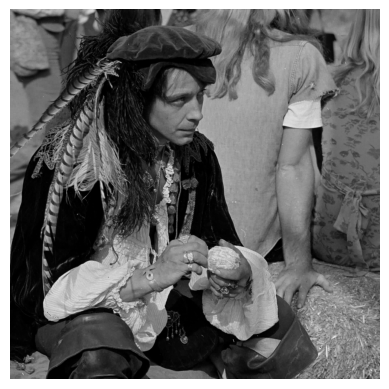

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image using PIL
image = Image.open("indigenous_decode_28.bmp")

# Display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

Calculate MSE

In [12]:
import numpy as np
from PIL import Image

# Load the images
img1 = Image.open('indigenous.png').convert('L') # Convert img1 to grayscale
img2 = Image.open('indigenous_decode_28.bmp')

# Convert images to NumPy arrays
img1_array = np.array(img1)
img2_array = np.array(img2)

# Calculate the MSE
mse = np.mean((img1_array - img2_array)**2)

# Print the MSE
print(f"MSE: {mse}")

MSE: 5.11109733581543


In [13]:
!pip install Pillow scikit-image

Calculate PSNR

In [14]:
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# 載入影像
img1 = Image.open('indigenous.png').convert('L') # Convert img1 to grayscale
img2 = Image.open('indigenous_decode_28.bmp')

# 將影像轉換為 NumPy 陣列
img1_array = np.array(img1)
img2_array = np.array(img2)

# 計算 PSNR
psnr = peak_signal_noise_ratio(img1_array, img2_array)

# 顯示 PSNR
print(f"PSNR: {psnr}")

PSNR: 40.935667042342104
